In [1]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw, graphviz_draw

# !pip install mqt.bench
from qiskit import transpile
from mqt.bench import CompilerSettings, QiskitSettings, TKETSettings, get_benchmark
from qiskit.transpiler import CouplingMap

from corral_crowding.topologies import (
    ring,
    square,
    tworing,
    hex_topo,
    corral,
    denselattice,
    build_graphs,
)

from corral_crowding import sqiswap  # update global equivalence library
from qiskit.converters import circuit_to_dag
from tqdm.notebook import tqdm
from qiskit import qasm2
import numpy as np
import matplotlib.pyplot as plt

# !pip install adjustText
from adjustText import adjust_text
import scienceplots
import lovelyplots

In [2]:
def topology_metric(cmap):
    distance_matrix = cmap.distance_matrix
    # average distance
    avg_distance = sum(
        [sum(row) / (len(distance_matrix) - 1) for row in distance_matrix]
    ) / len(distance_matrix)
    # average connectivity (average number of nodes that are distance 1 away)
    avg_connectivity = (
        1
        / len(distance_matrix)
        * sum([len([d for d in row if d == 1]) for row in distance_matrix])
    )
    # diameter
    # max distance between any two qubits
    diameter = max([max(row) for row in distance_matrix])
    return avg_distance, avg_connectivity, diameter


# names = ["ring", "square", "tworing", "hex_topo", "corral", "denselattice"]
# # for i, topology in enumerate([ring, square, tworing, hex_topo, corral, denselattice]):
# for i, topology in enumerate([square]):
#     snail_qubit_graph, qubit_connectivity = build_graphs(*topology)
# graphviz_draw(snail_qubit_graph, method="neato")
# display(graphviz_draw(qubit_connectivity, method="neato"))
# print(names[i])
# cmap = CouplingMap(qubit_connectivity.edge_list())
# print("num qubits", len(topology[1]))
# print("num snails", len(topology[0]))
# print(topology_metric(qubit_connectivity))
# print("\n")

In [3]:
qasmbench = [
    # "../qasmbench/adder_n10.qasm",
    "../qasmbench/multiplier_n15.qasm",
    "../qasmbench/sat_n11.qasm",
    # "../qasmbench/seca_n11.qasm",
    # "../qasmbench/ising_n10.qasm",
]


# inputqc = qasm2.load(benchmark_name)

In [4]:
mqt_bench_names = [
    "ae",
    # "dj",
    "qft",
    "qnn",
    "qpeexact",
    # "random",
    "su2random",
    "realamprandom",
    # "portfolioqaoa",
    # "qwalk-noancilla",
    # "grover-v-chain",
    # "tsp",
    # "shor",
    # "groundstate",
    # "graphstate",
    #  "wstate",
    # "vqe",
]

# inputqc = get_benchmark(benchmark_name=benchmark_name, level="alg", circuit_size=16)

In [5]:
topologies = {}

names = ["ring", "doublering", "corral", "square", "hex", "denselattice"]
for i, topology in enumerate([ring, square, tworing, hex_topo, corral, denselattice]):
    snail_qubit_graph, qubit_connectivity = build_graphs(*topology)
    cmap = CouplingMap(qubit_connectivity.edge_list())
    cmap.make_symmetric()
    topologies[names[i]] = cmap

In [6]:
isa = "cx"
for benchmark_name in qasmbench:
    print(f"  Processing circuit: {benchmark_name}")
    inputqc = qasm2.load(benchmark_name)

    tqc2 = transpile(
        inputqc,
        basis_gates=["u3", isa],
    )
    print(tqc2.count_ops()["cx"])


for benchmark_name in mqt_bench_names:
    print(f"  Processing circuit: {benchmark_name}")
    inputqc = get_benchmark(benchmark_name=benchmark_name, level="alg", circuit_size=16)
    tqc2 = transpile(
        inputqc,
        basis_gates=["u3", isa],
    )
    print(tqc2.count_ops()["cx"])

  Processing circuit: ../qasmbench/multiplier_n15.qasm
222
  Processing circuit: ../qasmbench/sat_n11.qasm
252
  Processing circuit: ae
240
  Processing circuit: qft
240
  Processing circuit: qnn
494
  Processing circuit: qpeexact
239
  Processing circuit: su2random
360
  Processing circuit: realamprandom
360


In [7]:
isa = "cx"  # xx_plus_yy
# use cx because qiskti doesn't have iswap (xx_plus_yy is sqiswap)
# cx and iswap are equivalent in terms of swap decompositions


def evaluate(input_qc, qubit_connectivity):
    # Transpile without basis gates
    tqc1 = transpile(input_qc, coupling_map=qubit_connectivity)
    tqc1_ops = tqc1.count_ops()
    tqc1_longest_path_ops = circuit_to_dag(tqc1).count_ops_longest_path()

    swap_count = tqc1_ops.get("swap", 0)
    swap_longest_path = tqc1_longest_path_ops.get("swap", 0)

    # Transpile with xx_plus_yy basis gates
    tqc2 = transpile(
        input_qc,
        coupling_map=qubit_connectivity,
        basis_gates=["u3", isa],
    )
    tqc2_ops = tqc2.count_ops()
    tqc2_longest_path_ops = circuit_to_dag(tqc2).count_ops_longest_path()

    two_qubit_gate_count = tqc2_ops.get(isa, 0)
    two_qubit_longest_path = tqc2_longest_path_ops.get(isa, 0)
    return swap_count, swap_longest_path, two_qubit_gate_count, two_qubit_longest_path


results = []

for topo_name, coupling_map in tqdm(topologies.items()):
    print(f"Evaluating topology: {topo_name}")
    for benchmark_name in qasmbench:
        print(f"  Processing circuit: {benchmark_name}")
        inputqc = qasm2.load(benchmark_name)
        swap_count, swap_longest_path, two_qubit_gate_count, two_qubit_longest_path = (
            evaluate(inputqc, coupling_map)
        )

        # Collect results
        results.append(
            {
                "Topology": topo_name,
                "Circuit": benchmark_name,
                "SWAPs (Total)": swap_count,
                "SWAPs (Longest Path)": swap_longest_path,
                "2Q Gates (Total)": two_qubit_gate_count,
                "2Q Gates (Longest Path)": two_qubit_longest_path,
            }
        )

    for benchmark_name in mqt_bench_names:
        print(f"  Processing circuit: {benchmark_name}")
        inputqc = get_benchmark(
            benchmark_name=benchmark_name, level="alg", circuit_size=16
        )
        swap_count, swap_longest_path, two_qubit_gate_count, two_qubit_longest_path = (
            evaluate(inputqc, coupling_map)
        )

        # Collect results
        results.append(
            {
                "Topology": topo_name,
                "Circuit": benchmark_name,
                "SWAPs (Total)": swap_count,
                "SWAPs (Longest Path)": swap_longest_path,
                "2Q Gates (Total)": two_qubit_gate_count,
                "2Q Gates (Longest Path)": two_qubit_longest_path,
            }
        )

  0%|          | 0/6 [00:00<?, ?it/s]

Evaluating topology: ring
  Processing circuit: ../qasmbench/multiplier_n15.qasm
  Processing circuit: ../qasmbench/sat_n11.qasm
  Processing circuit: ae
  Processing circuit: qft
  Processing circuit: qnn
  Processing circuit: qpeexact
  Processing circuit: su2random
  Processing circuit: realamprandom
Evaluating topology: doublering
  Processing circuit: ../qasmbench/multiplier_n15.qasm
  Processing circuit: ../qasmbench/sat_n11.qasm
  Processing circuit: ae
  Processing circuit: qft
  Processing circuit: qnn
  Processing circuit: qpeexact
  Processing circuit: su2random
  Processing circuit: realamprandom
Evaluating topology: corral
  Processing circuit: ../qasmbench/multiplier_n15.qasm
  Processing circuit: ../qasmbench/sat_n11.qasm
  Processing circuit: ae
  Processing circuit: qft
  Processing circuit: qnn
  Processing circuit: qpeexact
  Processing circuit: su2random
  Processing circuit: realamprandom
Evaluating topology: square
  Processing circuit: ../qasmbench/multiplier_n15

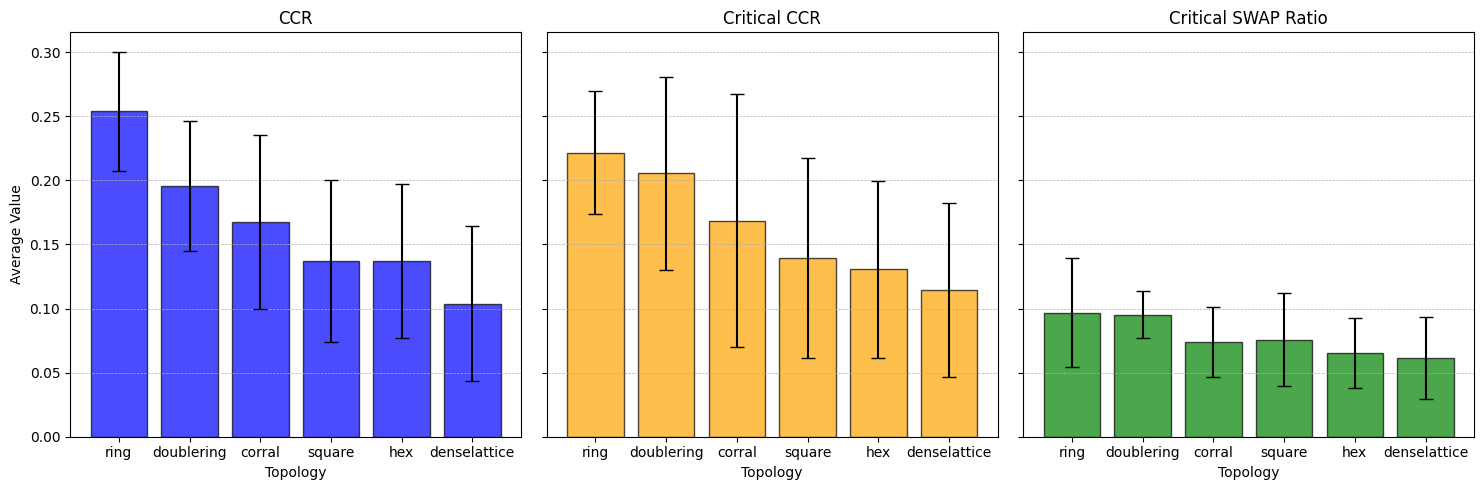

In [8]:
def calculate_metrics(results):
    """Calculate CCR, critical CCR, and CPSR for each benchmark and topology combination.
    Return a nested dictionary with the metrics.
    """
    communication_data = {}

    for result in results:
        topology = result["Topology"]
        circuit = result["Circuit"]
        n_swap = result["SWAPs (Total)"]
        g_swap = result["SWAPs (Longest Path)"]
        n_2q = result["2Q Gates (Total)"]
        g = result["2Q Gates (Longest Path)"]

        # Compute the metrics
        ccr = n_swap / n_2q if n_2q > 0 else 0
        critical_ccr = g_swap / g if g > 0 else 0
        cpsr = g_swap / n_2q if n_2q > 0 else 0

        # Organize the results into the dictionary
        if topology not in communication_data:
            communication_data[topology] = {}

        communication_data[topology][circuit] = {
            "CCR": ccr,
            "Critical CCR": critical_ccr,
            "Critical SWAP Ratio": cpsr,
        }

    return communication_data


# Calculate the metrics
communication_data = calculate_metrics(results)


# Function to average CCR metrics over all benchmarks
def average_metrics_with_error(communication_data):
    avg_metrics = {
        topology: {"CCR": [], "Critical CCR": [], "Critical SWAP Ratio": []}
        for topology in communication_data
    }

    for topology, benchmarks in communication_data.items():
        for circuit, metrics in benchmarks.items():
            avg_metrics[topology]["CCR"].append(metrics["CCR"])
            avg_metrics[topology]["Critical CCR"].append(metrics["Critical CCR"])
            avg_metrics[topology]["Critical SWAP Ratio"].append(
                metrics["Critical SWAP Ratio"]
            )

    avg_metrics_with_error = {}
    for topology, metric_lists in avg_metrics.items():
        avg_metrics_with_error[topology] = {
            "CCR": (np.mean(metric_lists["CCR"]), np.std(metric_lists["CCR"])),
            "Critical CCR": (
                np.mean(metric_lists["Critical CCR"]),
                np.std(metric_lists["Critical CCR"]),
            ),
            "Critical SWAP Ratio": (
                np.mean(metric_lists["Critical SWAP Ratio"]),
                np.std(metric_lists["Critical SWAP Ratio"]),
            ),
        }
    return avg_metrics_with_error


# Calculate average metrics with error
averaged_metrics = average_metrics_with_error(communication_data)

# Extract data for plotting
topology_names = ["ring", "doublering", "corral", "square", "hex", "denselattice"]
metrics_to_plot = ["CCR", "Critical CCR", "Critical SWAP Ratio"]
metric_colors = ["blue", "orange", "green"]

# Plotting
fig, ax = plt.subplots(1, len(metrics_to_plot), figsize=(15, 5), sharey=True)

for i, metric in enumerate(metrics_to_plot):
    averages = [averaged_metrics[topo][metric][0] for topo in topology_names]
    errors = [averaged_metrics[topo][metric][1] for topo in topology_names]
    ax[i].bar(
        topology_names,
        averages,
        yerr=errors,
        color=metric_colors[i],
        capsize=5,
        alpha=0.7,
        edgecolor="black",
    )
    ax[i].set_title(metric)
    ax[i].set_xlabel("Topology")
    ax[i].grid(axis="y", linestyle="--", linewidth=0.5)

ax[0].set_ylabel("Average Value")
plt.tight_layout()
plt.show()

In [9]:
def extract_topology_metrics(topologies):
    """Calculate avg_distance, avg_connectivity, and diameter for each topology."""
    topology_metrics = {}
    for name, cmap in topologies.items():
        if cmap is not None:
            avg_distance, avg_connectivity, diameter = topology_metric(cmap)
            topology_metrics[name] = {
                "avg_distance": avg_distance,
                "avg_connectivity": avg_connectivity,
                "diameter": diameter,
            }
    return topology_metrics


topology_metrics = extract_topology_metrics(topologies)

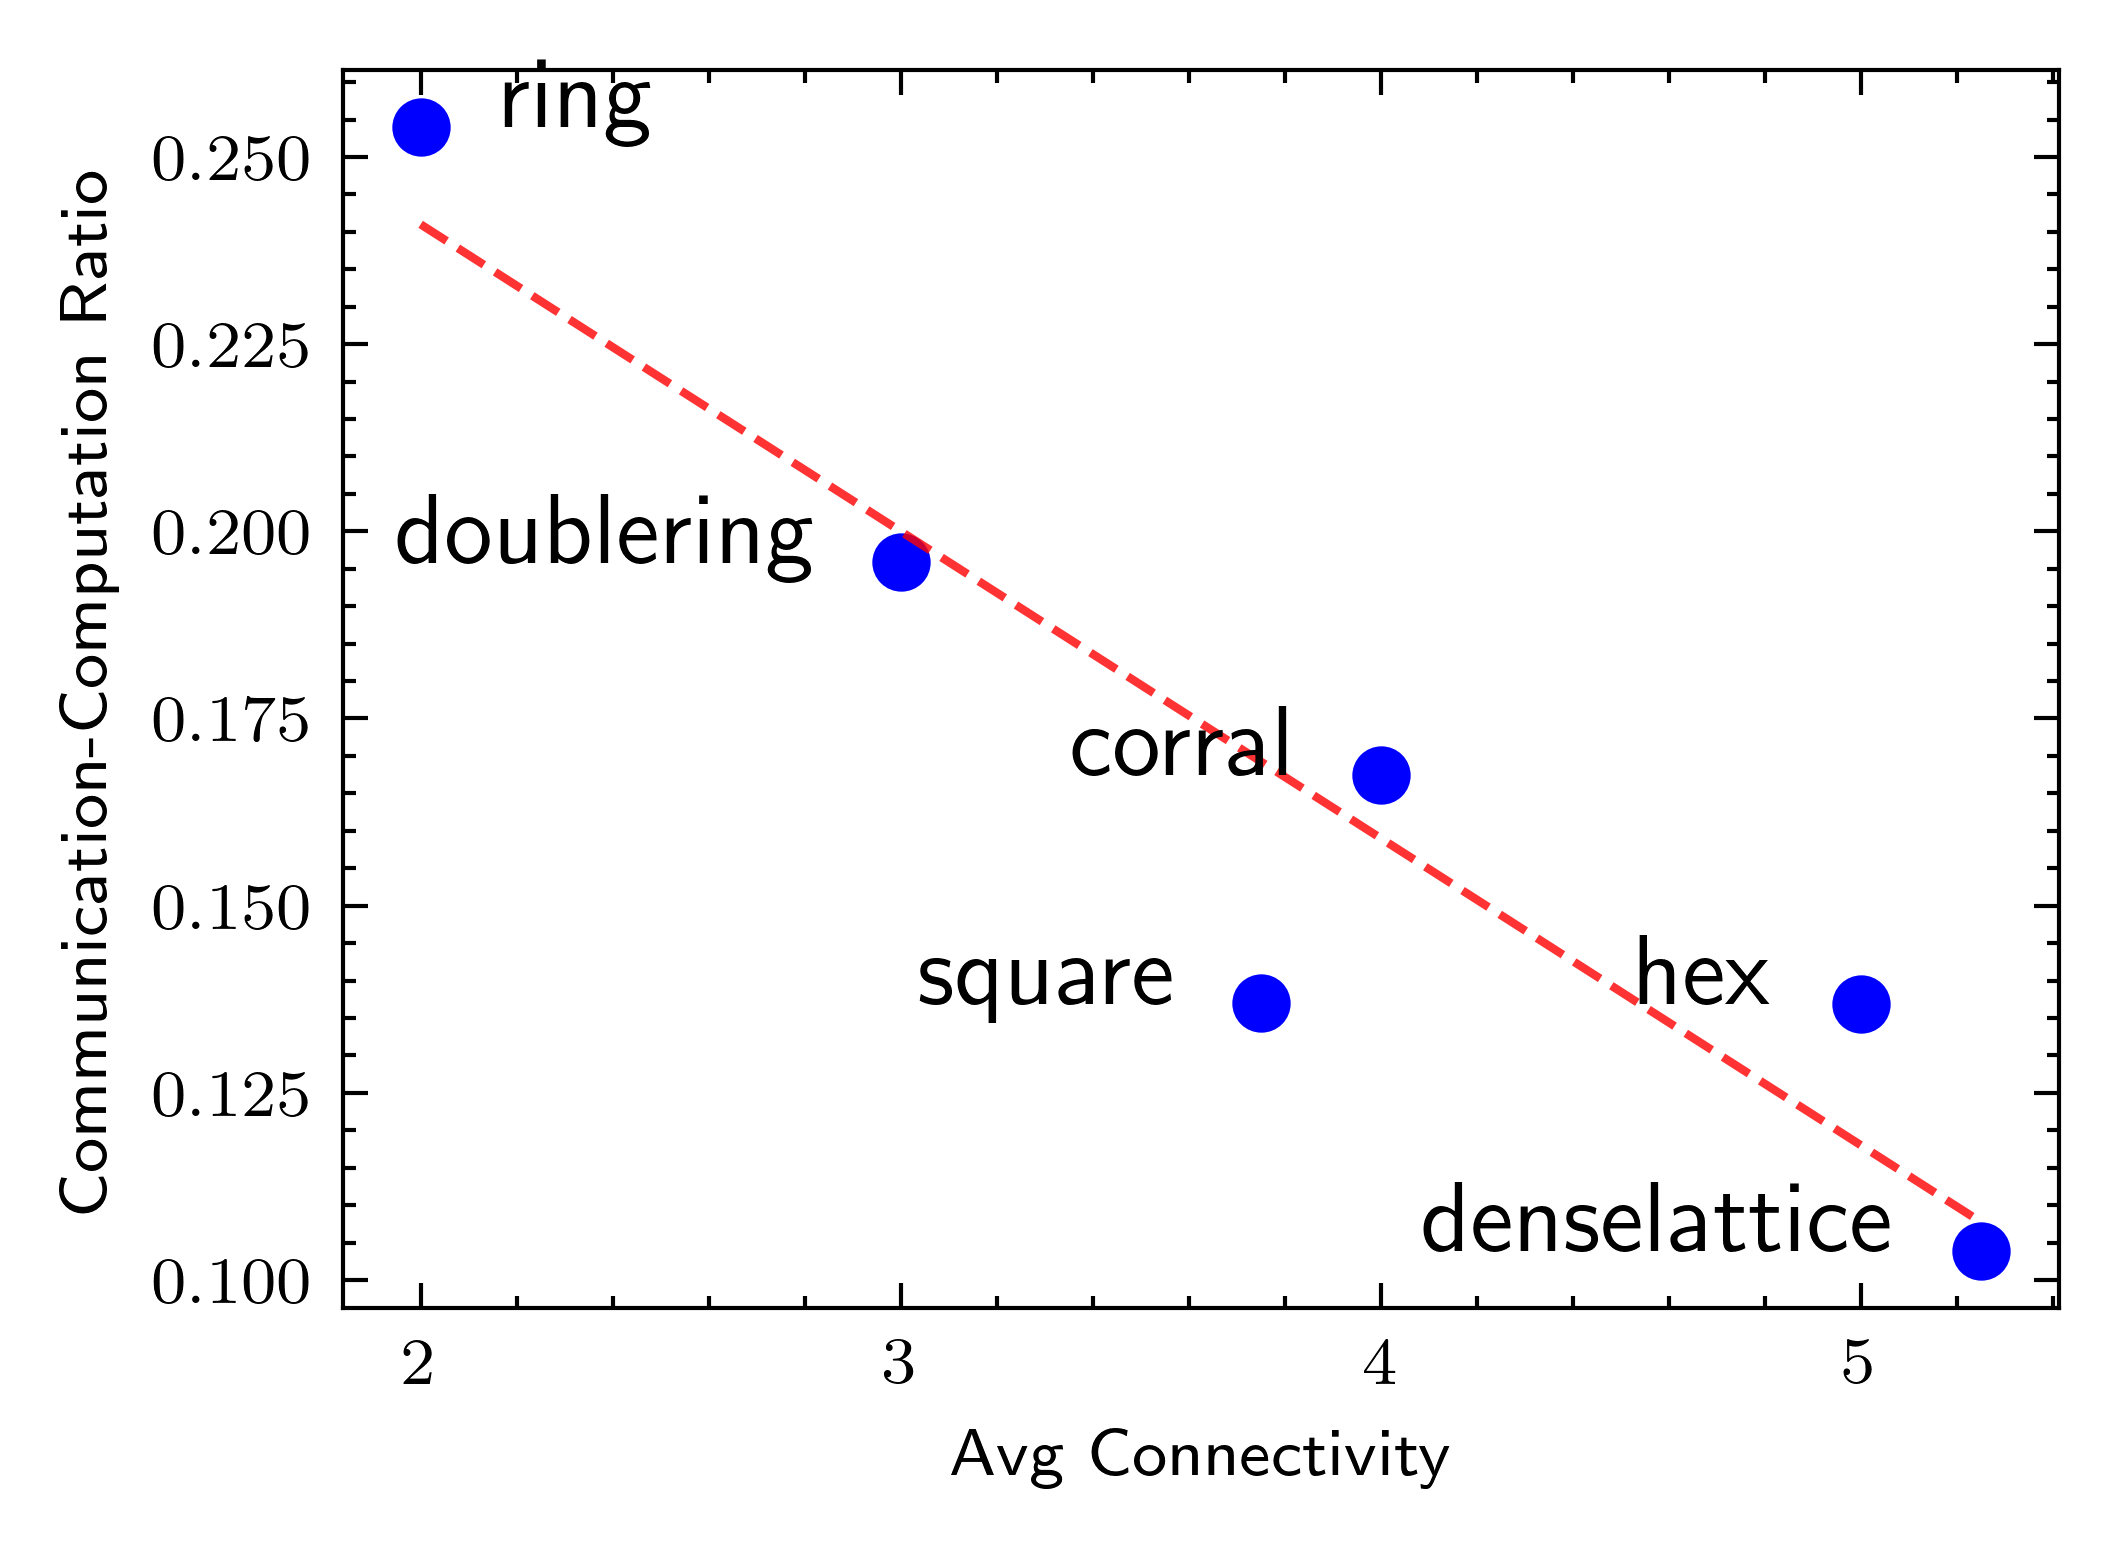

In [10]:
# Prepare data for plotting
plot_data = {"x": [], "CCR": [], "error": [], "labels": []}

for topology, metrics in topology_metrics.items():
    if topology in averaged_metrics:
        plot_data["x"].append(
            metrics["avg_connectivity"]
        )  # Use avg_connectivity as the x-axis
        plot_data["CCR"].append(averaged_metrics[topology]["CCR"][0])
        plot_data["error"].append(averaged_metrics[topology]["CCR"][1])
        plot_data["labels"].append(topology)

# Plotting
with plt.style.context(["ieee", "use_mathtext", "science"]):
    fig, ax = plt.subplots()  # figsize=(3.5, 2))

    # Scatter plot
    ax.scatter(
        plot_data["x"],
        plot_data["CCR"],
        label="CCR (data)",
        color="blue",
    )

    # Fit a line to the data
    coefficients = np.polyfit(plot_data["x"], plot_data["CCR"], 1)  # Linear fit
    fit_line = np.poly1d(coefficients)
    x_fit = np.linspace(min(plot_data["x"]), max(plot_data["x"]), 100)
    ax.plot(
        x_fit,
        fit_line(x_fit),
        label=f"Fit: y = {coefficients[0]:.2f}x + {coefficients[1]:.2f}",
        color="red",
        linestyle="--",
        alpha=0.8,  # Increase transparency
    )

    # Annotate each point with topology name
    for idx, label in enumerate(plot_data["labels"]):
        if label == "ring":
            ax.annotate(
                label,
                (plot_data["x"][idx], plot_data["CCR"][idx]),
                textcoords="offset points",
                xytext=(10, 0),  # Offset to the right of the point
                ha="left",
                fontsize=12,  # Larger font size for annotations
            )
        else:
            ax.annotate(
                label,
                (plot_data["x"][idx], plot_data["CCR"][idx]),
                textcoords="offset points",
                xytext=(-10, 0),  # Offset to the left of the point
                ha="right",
                fontsize=12,  # Larger font size for annotations
            )

    # Configure the plot
    ax.set_xlabel("Avg Connectivity")
    ax.set_ylabel("Communication-Computation Ratio")
    # ax.grid(True, linestyle="--", linewidth=0.5)

    plt.tight_layout()
    fig.savefig("CCR_vs_AvgConnectivity.pdf", bbox_inches="tight")
plt.show()

In [11]:
def simplify_circuit_name(circuit_name):
    """Simplify circuit names by extracting the last part and removing the extension."""
    return circuit_name.split("/")[-1].split("_")[0]


import matplotlib.pyplot as plt


# Metrics to plot
metrics_to_plot = [
    "SWAPs (Total)",
    "SWAPs (Longest Path)",
    "2Q Gates (Total)",
    "2Q Gates (Longest Path)",
]

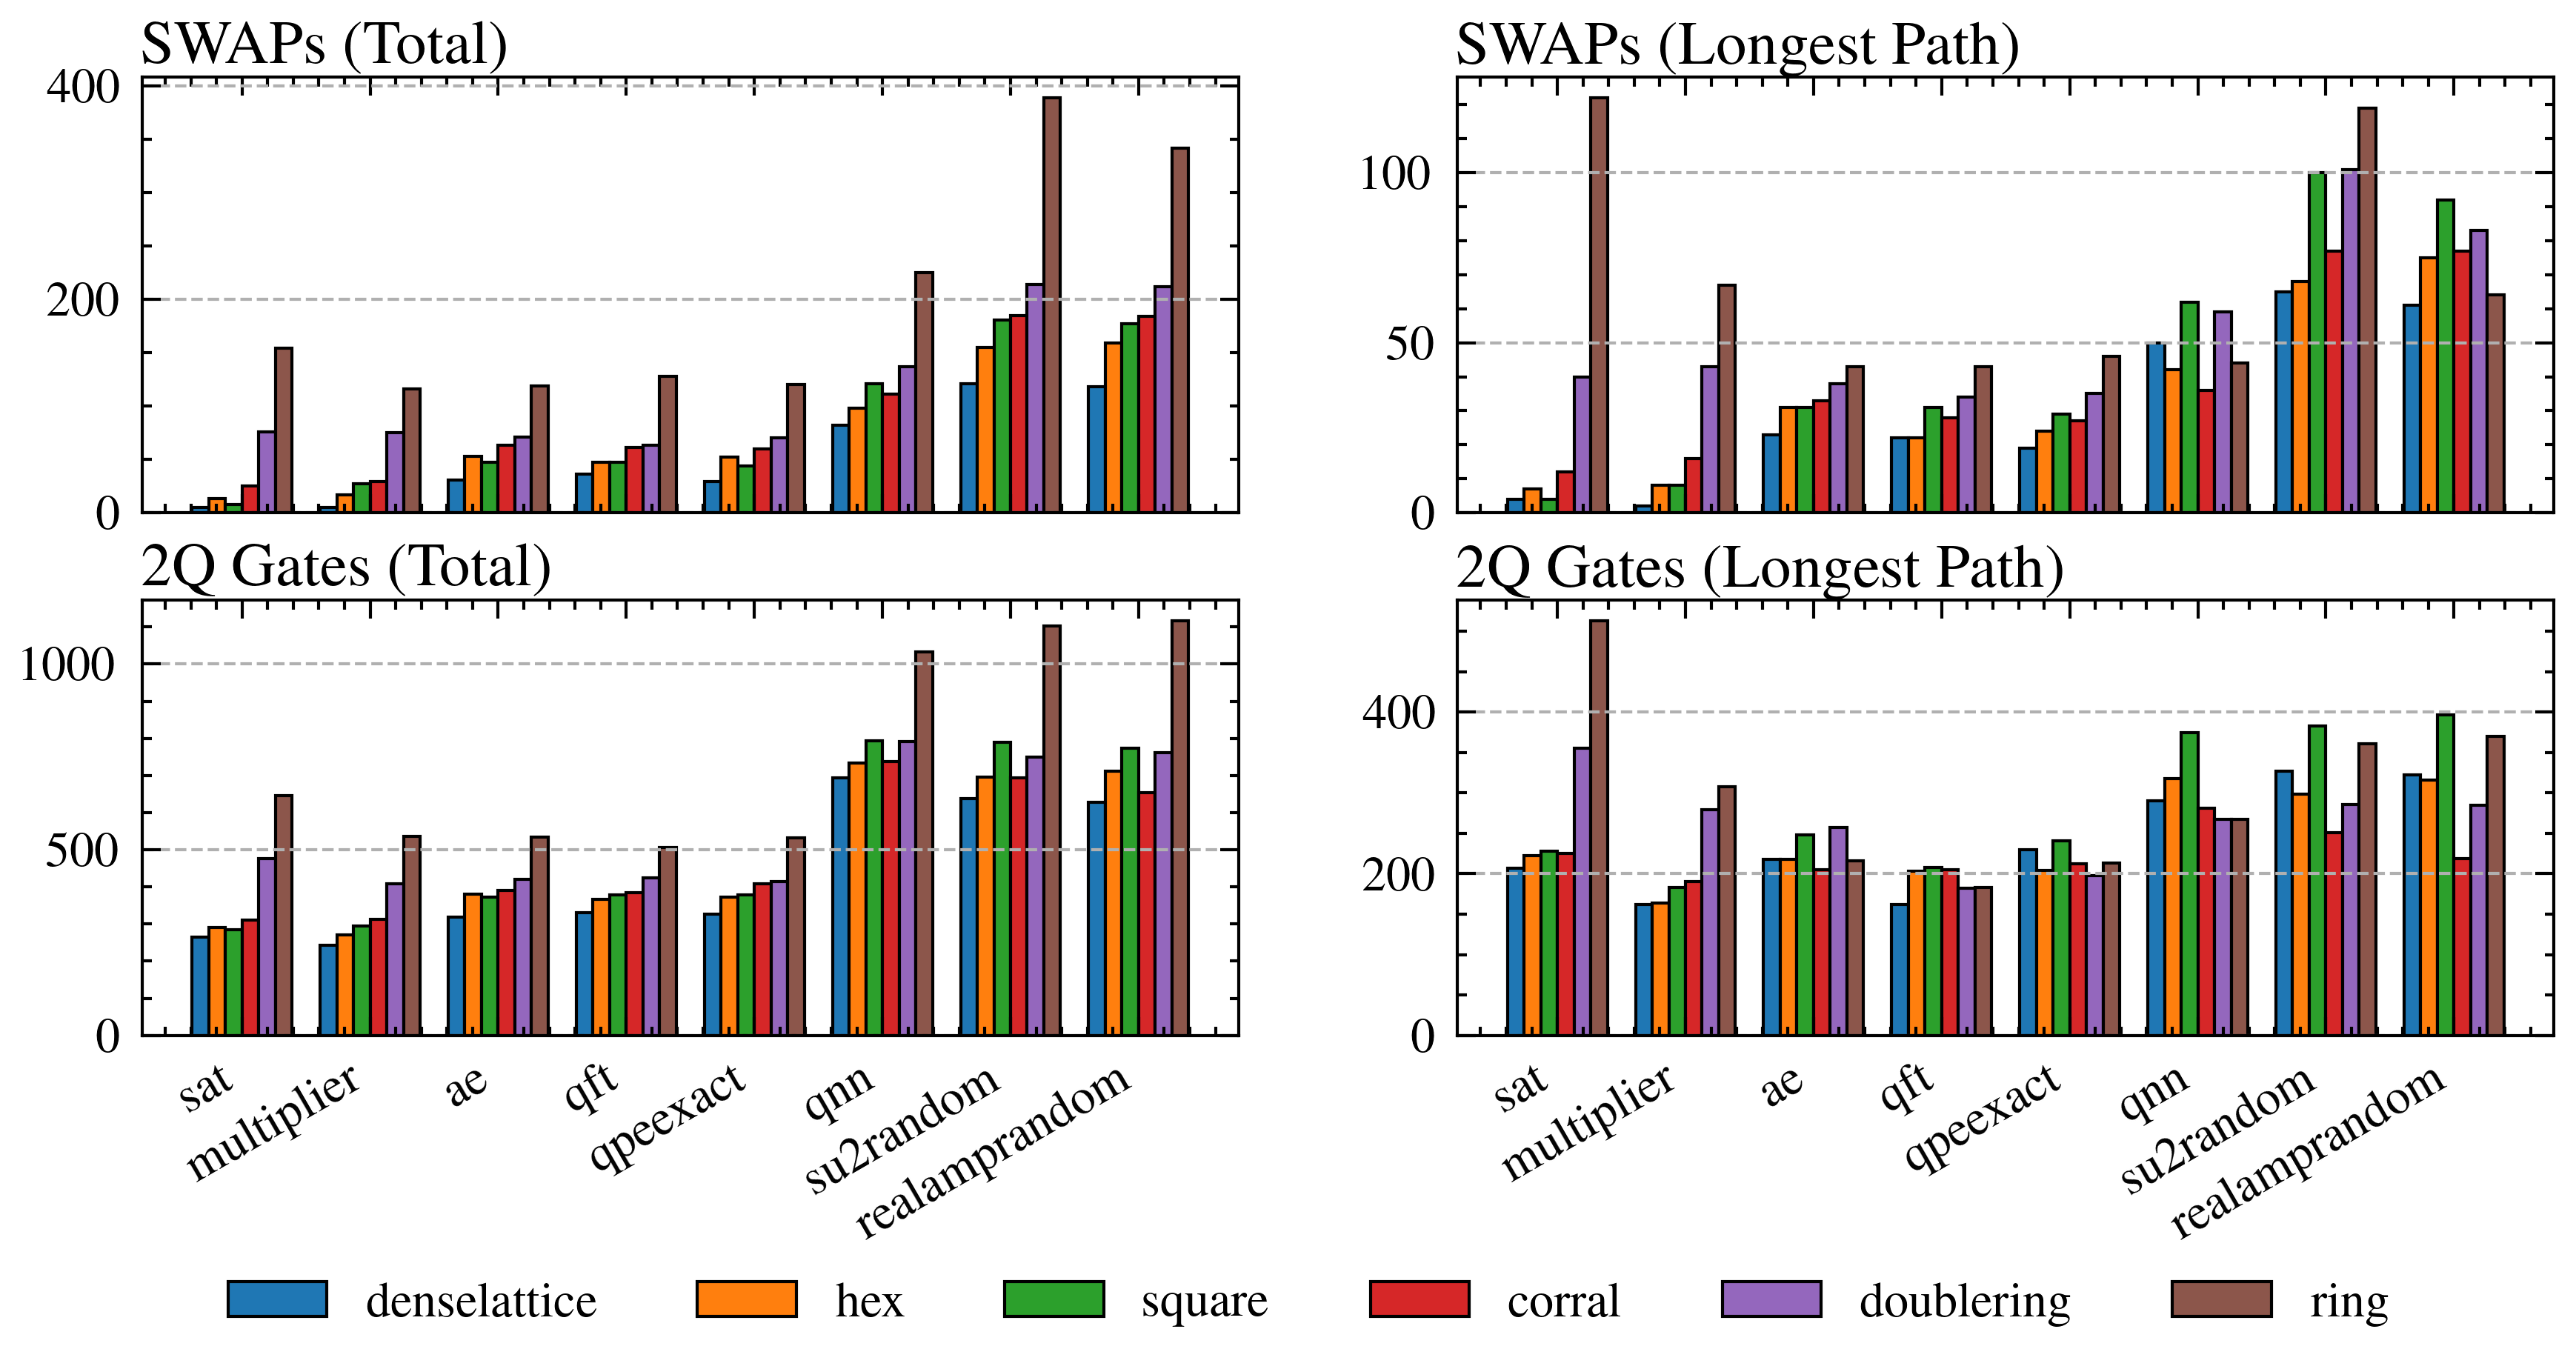

In [12]:
def create_full_grid_bar_chart_with_vertical_title(results, metrics, bar_width=0.13):
    """Generate a 2x2 grid of bar charts for all metrics, with independent y-axes for each subplot,
    and the y-axis label placed vertically as the title to save horizontal space.
    """
    # Define the order of circuits on the x-axis
    circuit_order = [
        "sat",
        "multiplier",
        "ae",
        "qft",
        "qpeexact",
        "qnn",
        "su2random",
        "realamprandom",
    ]

    # Define the desired order of topologies
    topology_order = ["denselattice", "hex", "square", "corral", "doublering", "ring"]

    # Group data by circuit and topology for all metrics
    grouped_data = {
        metric: {
            circuit: {topo: 0 for topo in topology_order} for circuit in circuit_order
        }
        for metric in metrics
    }
    for r in results:
        circuit_simple = simplify_circuit_name(r["Circuit"])
        for metric in metrics:
            if circuit_simple in circuit_order and r["Topology"] in topology_order:
                grouped_data[metric][circuit_simple][r["Topology"]] = r[metric]

    # Plotting
    with plt.style.context(["ieee", "use_mathtext", "science"]):
        fig, axes = plt.subplots(2, 2, figsize=(7, 2.8), sharex=True)
        axes = axes.flatten()

        for ax, metric in zip(axes, metrics):
            indices = np.arange(len(circuit_order))
            for i, topo in enumerate(topology_order):
                values = [
                    grouped_data[metric][circuit][topo] for circuit in circuit_order
                ]
                ax.bar(
                    indices + i * bar_width,
                    values,
                    bar_width,
                    label=topo,
                    color=plt.cm.tab10(i % 10),  # Use tab10 for color map
                    edgecolor="black",
                    linewidth=0.5,
                )
            ax.set_title(metric, rotation=0, loc="left", fontsize=10, pad=-20)
            ax.grid(True, axis="y", linestyle="--", linewidth=0.5)

        # Configure x-axis for all plots
        for ax in axes:
            ax.set_xticks(indices + bar_width * (len(topology_order) - 1) / 2)
            ax.set_xticklabels(circuit_order, rotation=30, ha="right")

        # Add legend centered below the plots
        handles, labels = axes[0].get_legend_handles_labels()
        fig.legend(
            handles,
            labels,
            loc="lower center",
            ncol=len(topology_order),
            bbox_to_anchor=(0.5, -0.16),
            frameon=False,
        )

        # plt.tight_layout(rect=[0, 0.3, 1, 1])  # Adjust layout to make space for legend
        fig.savefig("swap_counts.pdf", bbox_inches="tight")
        plt.show()


# Metrics to plot
metrics_to_plot_all = [
    "SWAPs (Total)",
    "SWAPs (Longest Path)",
    "2Q Gates (Total)",
    "2Q Gates (Longest Path)",
]

# Call the function with the vertical y-axis titles
create_full_grid_bar_chart_with_vertical_title(results, metrics_to_plot_all)

### investigating unknown gate fidelity scaling due to SNAIL crowding

first, unsure how to write scaling ansatz.
I will try
S(n) = e^{-alpha n} and S(n) = 1 / (1 + beta n)
functions that have fewer neighbors close to 1 and more neighbors diminish


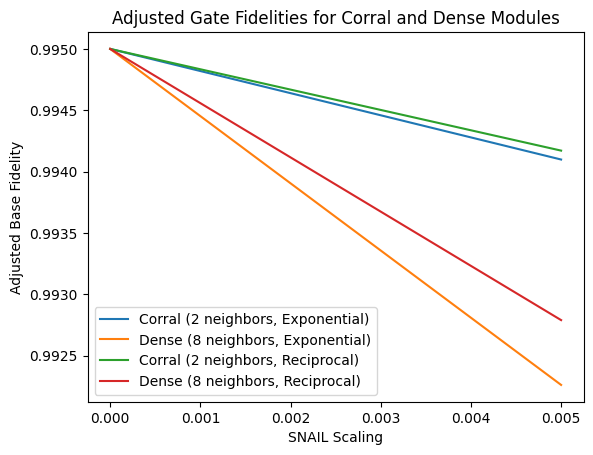

In [14]:
# Parameters
base_fidelity = 0.995
neighbors_corral = 2
neighbors_dense = 8

# SNAIL scaling factor range
snail_scaling = np.linspace(0, 0.005, 100)

# Base fidelity calculation for each module
corral_base_fidelities_exp = []
dense_base_fidelities_exp = []
corral_base_fidelities_rec = []
dense_base_fidelities_rec = []


# Updated scaling function for fidelity reduction
def scaling_function_exponential(n, alpha=0.1):
    return np.exp(-alpha * n)


def scaling_function_reciprocal(n, beta=0.1):
    return 1 / (1 + beta * n)


for scaling in snail_scaling:
    # Corral base fidelity using exponential scaling
    scaling_corral_exp = scaling_function_exponential(neighbors_corral)
    f_base_corral_exp = base_fidelity * (1 - scaling * (1 - scaling_corral_exp))
    f_base_corral_exp = max(
        0, min(1, f_base_corral_exp)
    )  # Ensure fidelity stays in [0, 1]
    corral_base_fidelities_exp.append(f_base_corral_exp)

    # Dense base fidelity using exponential scaling
    scaling_dense_exp = scaling_function_exponential(neighbors_dense)
    f_base_dense_exp = base_fidelity * (1 - scaling * (1 - scaling_dense_exp))
    f_base_dense_exp = max(
        0, min(1, f_base_dense_exp)
    )  # Ensure fidelity stays in [0, 1]
    dense_base_fidelities_exp.append(f_base_dense_exp)

    # Corral base fidelity using reciprocal scaling
    scaling_corral_rec = scaling_function_reciprocal(neighbors_corral)
    f_base_corral_rec = base_fidelity * (1 - scaling * (1 - scaling_corral_rec))
    f_base_corral_rec = max(
        0, min(1, f_base_corral_rec)
    )  # Ensure fidelity stays in [0, 1]
    corral_base_fidelities_rec.append(f_base_corral_rec)

    # Dense base fidelity using reciprocal scaling
    scaling_dense_rec = scaling_function_reciprocal(neighbors_dense)
    f_base_dense_rec = base_fidelity * (1 - scaling * (1 - scaling_dense_rec))
    f_base_dense_rec = max(
        0, min(1, f_base_dense_rec)
    )  # Ensure fidelity stays in [0, 1]
    dense_base_fidelities_rec.append(f_base_dense_rec)

# Plotting adjusted base fidelities on a single plot
plt.plot(
    snail_scaling, corral_base_fidelities_exp, label="Corral (2 neighbors, Exponential)"
)
plt.plot(
    snail_scaling, dense_base_fidelities_exp, label="Dense (8 neighbors, Exponential)"
)
plt.plot(
    snail_scaling, corral_base_fidelities_rec, label="Corral (2 neighbors, Reciprocal)"
)
plt.plot(
    snail_scaling, dense_base_fidelities_rec, label="Dense (8 neighbors, Reciprocal)"
)
plt.xlabel("SNAIL Scaling")
plt.ylabel("Adjusted Base Fidelity")
plt.title("Adjusted Gate Fidelities for Corral and Dense Modules")
plt.legend()
plt.show()

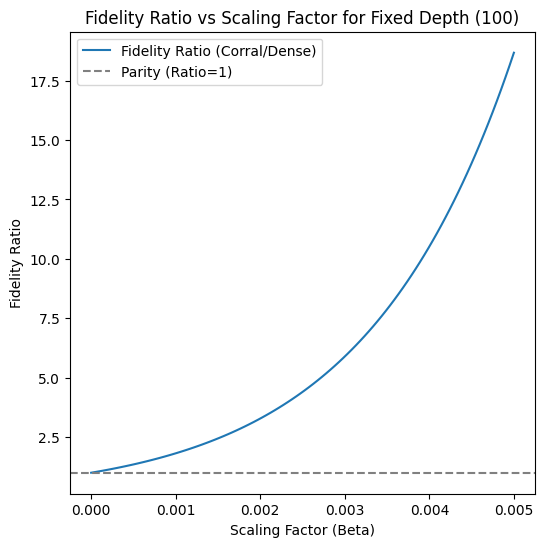

In [19]:
# Parameters
base_fidelity = 0.995
neighbors_corral = 2
neighbors_dense = 8

# Scaling factor range for reciprocal scaling
beta_values = np.linspace(0.00, 0.005, 100)


# Function for reciprocal scaling
def scaling_function_reciprocal(n, beta):
    return 1 / (1 + beta * n)


# Fixed depth for both Corral and Dense
fixed_depth = 100
fidelity_ratios = []

for beta in beta_values:
    # Corral and Dense fidelities
    scaling_corral = scaling_function_reciprocal(neighbors_corral, beta)
    scaling_dense = scaling_function_reciprocal(neighbors_dense, beta)

    corral_fidelity = (base_fidelity * scaling_corral) ** fixed_depth
    dense_fidelity = (base_fidelity * scaling_dense) ** fixed_depth

    # Ratio of fidelities
    ratio = corral_fidelity / dense_fidelity if dense_fidelity > 0 else 0
    fidelity_ratios.append(ratio)

# Plotting
plt.figure(figsize=(6, 6))
plt.plot(beta_values, fidelity_ratios, label="Fidelity Ratio (Corral/Dense)")
plt.xlabel("Scaling Factor (Beta)")
plt.ylabel("Fidelity Ratio")
plt.title("Fidelity Ratio vs Scaling Factor for Fixed Depth (100)")
plt.axhline(1, color="gray", linestyle="--", label="Parity (Ratio=1)")
plt.legend()
plt.show()

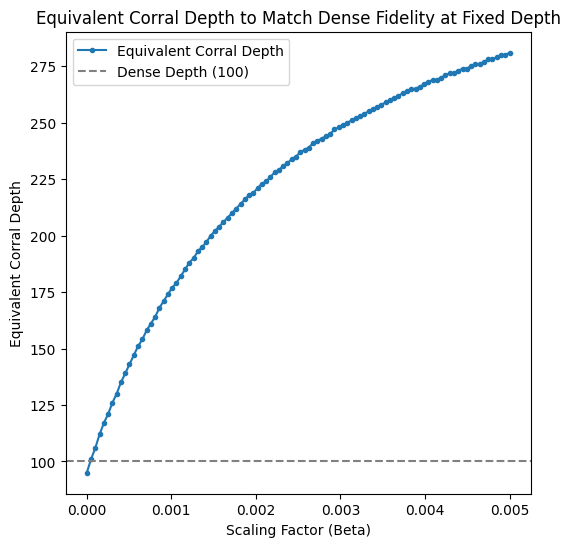

In [21]:
# Second Plot: Equivalent Corral Depth for Fixed Dense Depth
fixed_dense_depth = 100
equivalent_corral_depths = []
dense_ccr = 1.1
corral_ccr = 1.16

for beta in beta_values:
    scaling_corral = scaling_function_reciprocal(neighbors_corral, beta)
    scaling_dense = scaling_function_reciprocal(neighbors_dense, beta)

    dense_fidelity = (base_fidelity * scaling_dense) ** (fixed_dense_depth * dense_ccr)
    corral_depth = 0

    while True:
        corral_fidelity = (base_fidelity * scaling_corral) ** (
            corral_depth * corral_ccr
        )
        if (
            corral_fidelity <= dense_fidelity or corral_depth > 1000
        ):  # Avoid infinite loops
            break
        corral_depth += 1
    equivalent_corral_depths.append(corral_depth)

# Plotting
plt.figure(figsize=(6, 6))
plt.plot(
    beta_values, equivalent_corral_depths, label="Equivalent Corral Depth", marker="."
)
plt.axhline(fixed_dense_depth, color="gray", linestyle="--", label="Dense Depth (100)")
plt.xlabel("Scaling Factor (Beta)")
plt.ylabel("Equivalent Corral Depth")
plt.title("Equivalent Corral Depth to Match Dense Fidelity at Fixed Depth")
plt.legend()
plt.show()